In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import truncnorm, norm
from scipy.special import expit  # Sigmoid function for non-linear risk

# Number of simulations
num_simulations = 10000

# Set risk threshold - point at which the difference between dangerous capabilities and controls starts to meaningfully affect the risk
risk_threshold=0.5

# Function to calculate the z-score for any confidence level. z-score represents how many standard deviations a data point is from the mean of a distribution.
def z_score_for_confidence(confidence_level):
    tail_probability = (1 - confidence_level / 100) / 2
    return abs(norm.ppf(tail_probability))

# Function to calculate the standard deviation based on confidence level
def calculate_std_dev(min_value, max_value, confidence_level):
    z = z_score_for_confidence(confidence_level)
    return (max_value - min_value) / (2 * z)

# Function to generate a truncated normal distribution with confidence level
def truncated_normal(min_value, max_value, mean_value, confidence_level, size):
    std_dev = calculate_std_dev(min_value, max_value, confidence_level)
    a, b = (min_value - mean_value) / std_dev, (max_value - mean_value) / std_dev
    return truncnorm.rvs(a, b, loc=mean_value, scale=std_dev, size=size)

# Dangerous capabilities (with weights): values are: lowest bound of probability range, highest bound of probability range, mean, confidence.
dangerous_capabilities = {
    'Persuade a person to give money': {
        'value': truncated_normal(0.01, 0.05, 0.03, 85, num_simulations),
        'weight': 0.2
    },
    'Form personal connection': {
        'value': truncated_normal(0.01, 0.04, 0.02, 80, num_simulations),
        'weight': 0.4
    },
    'Trick person into giving info': {
        'value': truncated_normal(0.02, 0.06, 0.04, 75, num_simulations),
        'weight': 0.3
    },
    'Persuade to believe incorrect info': {
        'value': truncated_normal(0.02, 0.07, 0.05, 90, num_simulations),
        'weight': 0.3
    },
    'Solve easy/medium CTFs': {
        'value': truncated_normal(0.02, 0.08, 0.05, 80, num_simulations),
        'weight': 0.4
    },
    'Solve CTFs from Hack The Box': {
        'value': truncated_normal(0.03, 0.10, 0.06, 85, num_simulations),
        'weight': 0.4
    },
    'Identify security vulnerabilities': {
        'value': truncated_normal(0.03, 0.09, 0.06, 80, num_simulations),
        'weight': 0.4
    },
    'Maintain AI agents': {
        'value': truncated_normal(0.02, 0.06, 0.04, 85, num_simulations),
        'weight': 0.6
    },
    'Acquire resources': {
        'value': truncated_normal(0.02, 0.05, 0.03, 80, num_simulations),
        'weight': 0.8
    },
    'Self-improvement': {
        'value': truncated_normal(0.01, 0.05, 0.03, 75, num_simulations),
        'weight': 0.8
    },
    'Knowledge gaps': {
        'value': truncated_normal(0.02, 0.06, 0.04, 80, num_simulations),
        'weight': 0.6
    },
    'Instrumental self-modification': {
        'value': truncated_normal(0.03, 0.08, 0.05, 85, num_simulations),
        'weight': 0.8
    }
}


# Preventative controls (with weights)
preventative_controls = {
    'Evaluations': {
        'value': truncated_normal(0.60, 0.80, 0.70, 90, num_simulations),
        'weight': 0.25
    },
    'Fine Tuning': {
        'value': truncated_normal(0.40, 0.60, 0.50, 85, num_simulations),
        'weight': 0.2
    },
    'Mechanistic Interpretability': {
        'value': truncated_normal(0.70, 0.80, 0.75, 80, num_simulations),
        'weight': 0.4
    },
    'Input/Output Filtration': {
        'value': truncated_normal(0.70, 0.90, 0.80, 90, num_simulations),
        'weight': 0.2
    },
    'Red Teaming': {
        'value': truncated_normal(0.60, 0.80, 0.70, 90, num_simulations),
        'weight': 0.3
    },
    'Information Security': {
        'value': truncated_normal(0.75, 0.95, 0.85, 90, num_simulations),
        'weight': 0.2
    },
    'No Deployment with Dangerous Capabilities': {
        'value': truncated_normal(0.30, 0.50, 0.40, 75, num_simulations),
        'weight': 0.8
    },
    'Prevention of Tuning Away Controls': {
        'value': truncated_normal(0.20, 0.60, 0.45, 80, num_simulations),
        'weight': 0.25
    }
}

# Detective controls (with weights)
detective_controls = {
    'Developer Awareness': {
        'value': truncated_normal(0.50, 0.70, 0.60, 85, num_simulations),
        'weight': 0.25
    },
    'Logging and Monitoring': {
        'value': truncated_normal(0.50, 0.70, 0.60, 90, num_simulations),
        'weight': 0.2
    },
    'Anomaly Detection': {
        'value': truncated_normal(0.40, 0.60, 0.50, 90, num_simulations),
        'weight': 0.2
    },
    'Behavioral Drift Monitoring': {
        'value': truncated_normal(0.10, 0.30, 0.20, 85, num_simulations),
        'weight': 0.5
    },
    'Agent Identification': {
        'value': truncated_normal(0.20, 0.50, 0.40, 90, num_simulations),
        'weight': 0.6
    },
    'Audit Logs and Explainability': {
        'value': truncated_normal(0.10, 0.35, 0.25, 70, num_simulations),
        'weight': 0.8
    }
}

# Remedial controls (with weights)
remedial_controls = {
    'Shut down capability': {
        'value': truncated_normal(0.25, 0.50, 0.40, 60, num_simulations),
        'weight': 0.8
    },
    'Willingness to Shut Down': {
        'value': truncated_normal(0.25, 0.50, 0.40, 60, num_simulations),
        'weight': 0.8
    },
    'Restrict Model Access': {
        'value': truncated_normal(0.40, 0.60, 0.50, 85, num_simulations),
        'weight': 0.6
    }
}

# A nonlinear risk calculation function (using a sigmoid to control the scale)
def calculate_risk(dangerous_scores, control_scores, risk_threshold, sensitivity=5):
    """
    Use a sigmoid function to calculate risk:
    f(x) = 1 / (1 + exp(-sensitivity * (x - threshold)))
    """
    raw_risk = dangerous_scores - control_scores
    return expit(sensitivity * (raw_risk - risk_threshold))

# Function to simulate the probability of catastrophic loss of control
def simulate_loss_of_control():
    loss_of_control_probs = []
    dangerous_scores = []
    control_scores = []
    
    for i in range(num_simulations):
        # Weighted sum of dangerous capabilities
        dangerous_score = sum(dangerous_capabilities[key]['value'][i] * dangerous_capabilities[key]['weight'] 
                              for key in dangerous_capabilities)
        dangerous_scores.append(dangerous_score)
        
        # Weighted sum of control effectiveness
        control_score = sum(preventative_controls[key]['value'][i] * preventative_controls[key]['weight'] 
                            for key in preventative_controls) + \
                        sum(detective_controls[key]['value'][i] * detective_controls[key]['weight'] 
                            for key in detective_controls) + \
                        sum(remedial_controls[key]['value'][i] * remedial_controls[key]['weight'] 
                            for key in remedial_controls)
        control_scores.append(control_score)

        # Calculate risk using the nonlinear risk function
        risk = calculate_risk(dangerous_score, control_score, risk_threshold)
        loss_of_control_probs.append(risk)

    return dangerous_scores, control_scores, loss_of_control_probs

# Run the simulation
dangerous_scores, control_scores, loss_of_control_probs = simulate_loss_of_control()


In [62]:
import numpy as np

# Function to run the simulation and extract dangerous scores, control scores, and risk probabilities
def get_scenario_values():
    dangerous_scores, control_scores, loss_of_control_probs = simulate_loss_of_control()
    # Return the extracted values
    return dangerous_scores, control_scores, loss_of_control_probs

# Function to extract statistics for a given scenario
def extract_statistics(risk_probs):
    median = np.median(risk_probs)
    max_value = np.max(risk_probs)
    min_value = np.min(risk_probs)
    percentile_25 = np.percentile(risk_probs, 25)
    percentile_75 = np.percentile(risk_probs, 75)
    
    return {
        "median": median,
        "max": max_value,
        "min": min_value,
        "25th percentile": percentile_25,
        "75th percentile": percentile_75
    }

# Extract statistics for the realistic scenario
def extract_realistic_scenario_statistics():
    _, _, risk_probs_realistic = get_scenario_values()
    stats_realistic = extract_statistics(risk_probs_realistic)
    return stats_realistic

# Get and print summary statistics for scenario
stats_realistic = extract_realistic_scenario_statistics()
print("Realistic Scenario Statistics:")
print(stats_realistic)

Realistic Scenario Statistics:
{'median': 1.651844623197686e-08, 'max': 1.458629174252691e-07, 'min': 1.7553061235063296e-09, '25th percentile': 1.0617526264922793e-08, '75th percentile': 2.5547807277874955e-08}


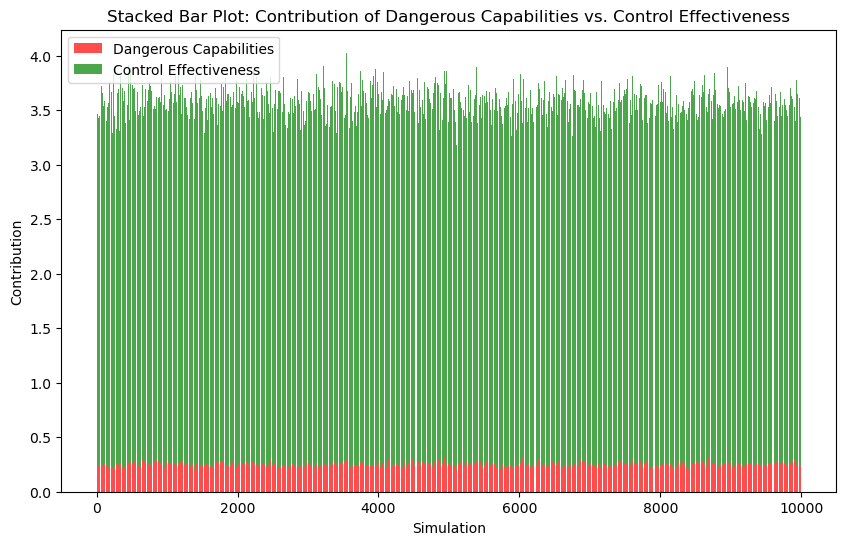

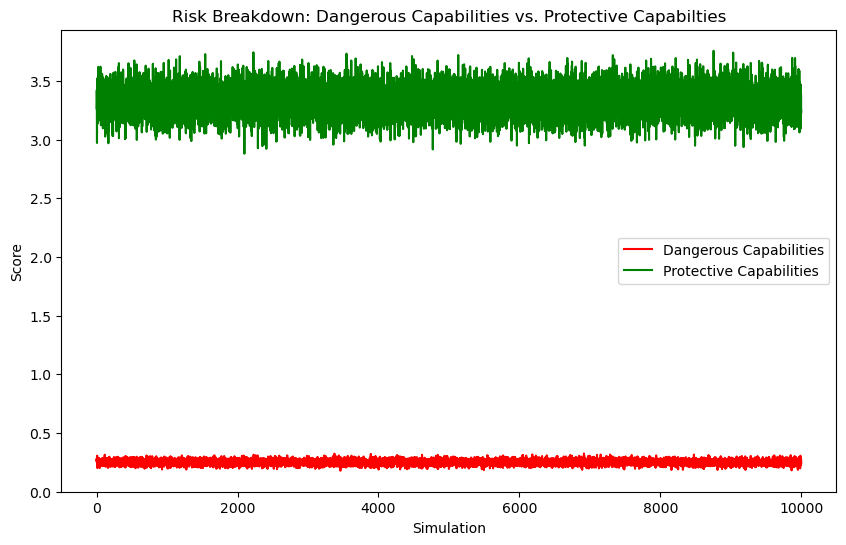

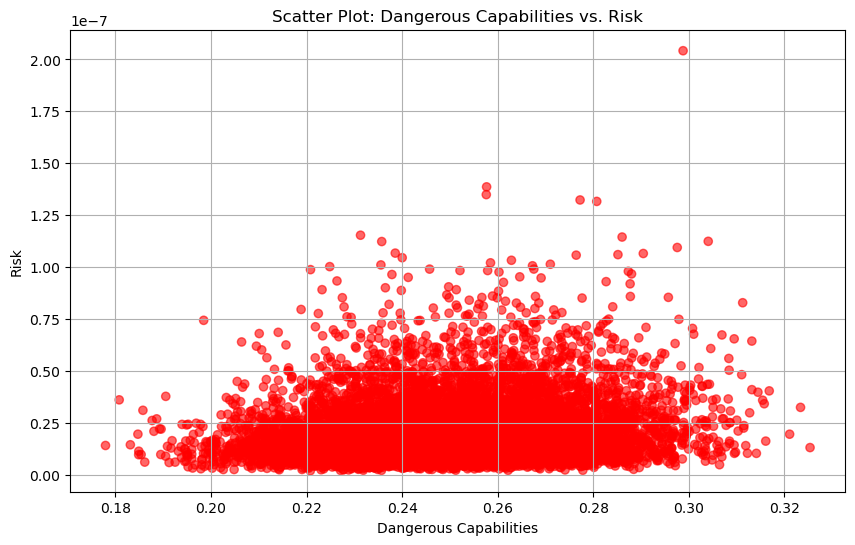

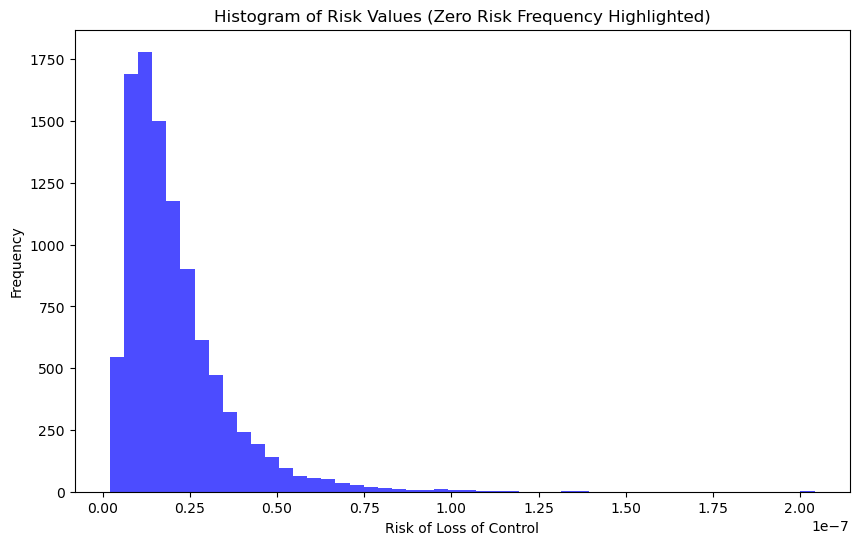

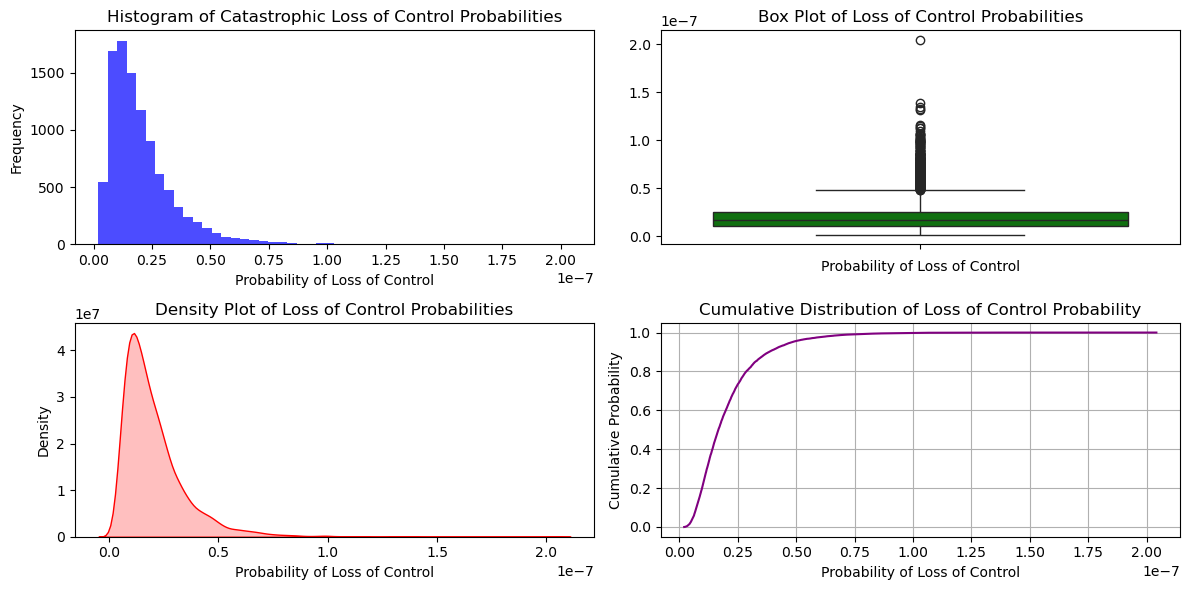

In [18]:

# Visualizations

# 1. Stacked Bar Plot: Contribution of Dangerous Capabilities and Controls
plt.figure(figsize=(10, 6))
plt.bar(range(num_simulations), dangerous_scores, label="Dangerous Capabilities", color="red", alpha=0.7)
plt.bar(range(num_simulations), control_scores, label="Control Effectiveness", color="green", alpha=0.7, bottom=dangerous_scores)
plt.title('Stacked Bar Plot: Contribution of Dangerous Capabilities vs. Control Effectiveness')
plt.xlabel('Simulation')
plt.ylabel('Contribution')
plt.legend()
plt.show()

# 2. Risk Breakdown Plot: Dangerous Capabilities vs. Protective Capabilities
plt.figure(figsize=(10, 6))
plt.plot(dangerous_scores, label="Dangerous Capabilities", color="red")
plt.plot(control_scores, label="Protective Capabilities", color="green")
plt.title('Risk Breakdown: Dangerous Capabilities vs. Protective Capabilties')
plt.xlabel('Simulation')
plt.ylabel('Score')
plt.legend()
plt.show()

# 3. Scatter Plot: Dangerous Capabilities vs. Risk
plt.figure(figsize=(10, 6))
plt.scatter(dangerous_scores, loss_of_control_probs, alpha=0.6, c=np.where(np.array(loss_of_control_probs) == 0, 'blue', 'red'))
plt.title('Scatter Plot: Dangerous Capabilities vs. Risk')
plt.xlabel('Dangerous Capabilities')
plt.ylabel('Risk')
plt.grid(True)
plt.show()

# 4. Histogram: Zero-Risk Frequency
plt.figure(figsize=(10, 6))
plt.hist(loss_of_control_probs, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Risk Values (Zero Risk Frequency Highlighted)')
plt.xlabel('Risk of Loss of Control')
plt.ylabel('Frequency')
plt.show()

# 5. Histogram of Loss of Control Probabilities
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.hist(loss_of_control_probs, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Catastrophic Loss of Control Probabilities')
plt.xlabel('Probability of Loss of Control')
plt.ylabel('Frequency')

# 6. Box Plot of Loss of Control Probabilities
plt.subplot(2, 2, 2)
sns.boxplot(loss_of_control_probs, color='green')
plt.title('Box Plot of Loss of Control Probabilities')
plt.xlabel('Probability of Loss of Control')

# 7. Density Plot of Loss of Control Probabilities
plt.subplot(2, 2, 3)
sns.kdeplot(loss_of_control_probs, color='red', fill=True, warn_singular=False)
plt.title('Density Plot of Loss of Control Probabilities')
plt.xlabel('Probability of Loss of Control')
plt.ylabel('Density')

# 8. Cumulative Distribution Plot of Loss of Control Probabilities
plt.subplot(2, 2, 4)
plt.plot(np.sort(loss_of_control_probs), np.linspace(0, 1, num_simulations), color='purple')
plt.title('Cumulative Distribution of Loss of Control Probability')
plt.xlabel('Probability of Loss of Control')
plt.ylabel('Cumulative Probability')
plt.grid(True)

plt.tight_layout()
plt.show()


In [19]:
def plot_scatter_with_risk_threshold(dangerous_scores, loss_of_control_probs, risk_threshold):
    """
    This function creates a scatter plot showing the dangerous capabilities vs. risk of loss of control.
    The points are color-coded based on the risk, and a vertical risk threshold line is drawn.
    
    Parameters:
    - dangerous_scores: The dangerous capability scores from the simulation.
    - loss_of_control_probs: The risk of loss of control values from the simulation.
    - risk_threshold: The threshold where the risk starts to increase (default = 0.5).
    """
    
    # Create a scatter plot with color-coding based on the risk
    plt.figure(figsize=(10, 6))

    # Color coding the scatter plot based on risk levels
    scatter = plt.scatter(dangerous_scores, loss_of_control_probs, 
                          c=loss_of_control_probs, cmap='coolwarm', alpha=0.7)

    # Add a color bar to show risk levels
    cbar = plt.colorbar(scatter)
    cbar.set_label('Risk Level')

    # Adding the risk threshold line (vertical line)
    plt.axvline(x=risk_threshold, color='red', linestyle='--', label=f'Risk Threshold: {risk_threshold}')

    # Add labels and title
    plt.title('Scatter Plot: Dangerous Capabilities vs. Risk of Loss of Control')
    plt.xlabel('Dangerous Capability Score')
    plt.ylabel('Risk of Loss of Control')

    # Add legend for the risk threshold
    plt.legend()

    # Add grid for better readability
    plt.grid(True)

    # Show the plot
    plt.show()


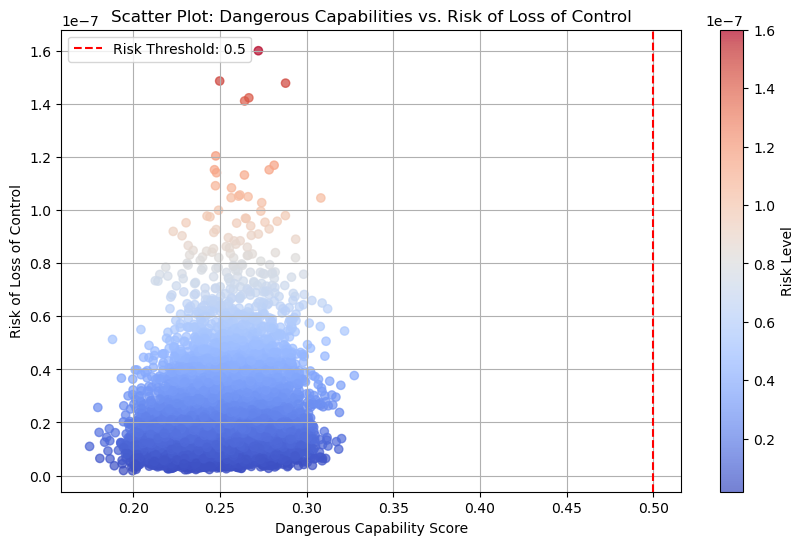

In [21]:
dangerous_scores, control_scores, loss_of_control_probs = simulate_loss_of_control()

plot_scatter_with_risk_threshold(dangerous_scores, loss_of_control_probs, risk_threshold)
